# 目的
1. 二つの入力の類似度を見るため、f=cossim(encoder(input1), encoder(input2)) を見る。
2. その理由を知るため、df/dinput1, df/input2 を見る

## やること

1. MNIST, DCAE (うまくいっているモデル)　で試す
2. KDDcup, (D)AE で試す
3. 遠藤メソッド(certの方)　で試す

In [2]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# 必要パッケージのimport
import os, sys, re, time
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import colorsys
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib
from functools import reduce

import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.core import Lambda

Using TensorFlow backend.


In [4]:
import model_vis
%aimport model_vis
%autoreload 1

## MNIST, AE

データセット用意、model作成、訓練、(復元画像見て)test, saliency見る

In [5]:
# データセットの用意
from keras.datasets import mnist

(mnist_train, mnist_label_train), (mnist_test, mnist_label_test) = mnist.load_data()
# model に投げる形に変換
mnist_train = mnist_train.astype('float32')/255.
mnist_train = mnist_train.reshape((len(mnist_train), np.prod(mnist_train.shape[1:])))
# mnist_train = np.expand_dims(mnist_train, -1)
mnist_label_train = np.eye(10)[mnist_label_train]

mnist_test = mnist_test.astype('float32')/255.
mnist_test = mnist_test.reshape((len(mnist_test), np.prod(mnist_test.shape[1:])))
# mnist_test = np.expand_dims(mnist_test, -1)
mnist_label_test = np.eye(10)[mnist_label_test]

In [6]:
# model 作成
encoding_dim = 32
input_img = Input(shape=(784,))
# encoded_mnist = Dense(150, activation='relu')(input_img)
encoded_mnist = Dense(encoding_dim, activation='relu')(input_img)
# decoded_mnist = Dense(150, activation='relu')(encoded_mnist)
decoded_mnist = Dense(784, activation='sigmoid')(encoded_mnist)

ae_mnist = Model(input=input_img, output=decoded_mnist)
encoder_mnist = Model(input_img, encoded_mnist)
tf.keras.backend.get_session().run(tf.global_variables_initializer())
ae_mnist.compile(optimizer='adadelta', loss='binary_crossentropy')
ae_mnist.summary()

W1016 14:28:19.571869 4373704000 deprecation_wrapper.py:119] From /Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1016 14:28:19.601797 4373704000 deprecation_wrapper.py:119] From /Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1016 14:28:19.631597 4373704000 deprecation_wrapper.py:119] From /Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

/Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Mode

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [7]:
# 訓練
ae_mnist.fit(mnist_train, mnist_train,
                epochs=10,
                batch_size=256,
                shuffle=True)

W1016 14:28:19.959067 4373704000 deprecation_wrapper.py:119] From /Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
60000/60000 [==============================] - 9s 142us/step - loss: 0.3594
Epoch 2/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.2636
Epoch 3/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.2408
Epoch 4/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.2201
Epoch 5/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.2052
Epoch 6/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.1945
Epoch 7/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.1863
Epoch 8/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.1796
Epoch 9/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.1739
Epoch 10/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.1688


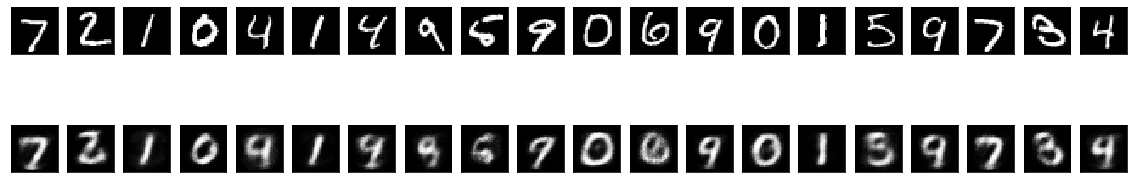

In [48]:
# test
n = 20
decoded_img = ae_mnist.predict(mnist_test[:n])

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### ずらすと壊滅的

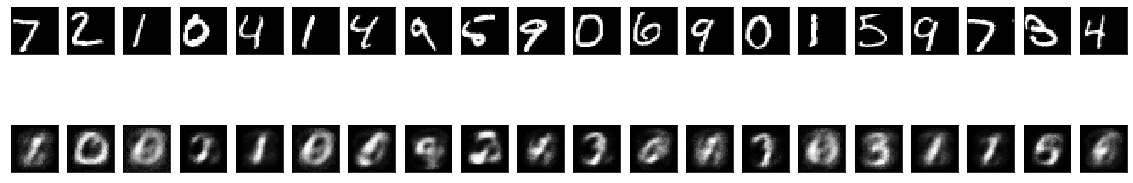

In [49]:
# test
n = 20
test = mnist_test_dcae[:n]
test = np.concatenate((test[:, :, 5:],test[:, :, :5]), axis=2).reshape(n, -1)
decoded_img = ae_mnist.predict(test)

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [33]:
mnist_label = (mnist_label_test[:80] @ np.arange(10)).astype(int)
model_vis.model_vis(encoder_mnist, mnist_test[:80], mnist_label, trans_data=model_vis.trans_data_mnist, output_path='./html/mnist_ae.html', output_title='mnist_ae')

# mnist dcae

In [43]:
# データセットの用意
from keras.datasets import mnist
# AEの時にやった処理
(mnist_train, mnist_label_train), (mnist_test, mnist_label_test) = mnist.load_data()
mnist_train = mnist_train.astype('float32')/255.
mnist_train = mnist_train.reshape((len(mnist_train), np.prod(mnist_train.shape[1:])))
mnist_label_train = np.eye(10)[mnist_label_train]

mnist_test = mnist_test.astype('float32')/255.
mnist_test = mnist_test.reshape((len(mnist_test), np.prod(mnist_test.shape[1:])))
mnist_label_test = np.eye(10)[mnist_label_test]

# DCAE ようにreshape
mnist_train_dcae = mnist_train.reshape(-1, 28, 28, 1)
mnist_test_dcae = mnist_test.reshape(-1, 28, 28, 1)

In [13]:
input_img_dcae = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img_dcae)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded_mnist_dcae = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_mnist_dcae)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded_mnist_dcae = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

dcae = Model(input_img_dcae, decoded_mnist_dcae)
encoder_mnist_dcae = Model(input_img_dcae, encoded_mnist_dcae)
tf.keras.backend.get_session().run(tf.global_variables_initializer())
dcae.compile(optimizer='adadelta', loss='binary_crossentropy')
dcae.summary()

W1016 14:30:54.767674 4373704000 deprecation_wrapper.py:119] From /Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1016 14:30:54.857286 4373704000 deprecation_wrapper.py:119] From /Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [14]:
# 訓練
dcae.fit(mnist_train_dcae, mnist_train_dcae,
                epochs=10,
                batch_size=256,
                shuffle=True)

Epoch 1/10
60000/60000 [==============================] - 96s 2ms/step - loss: 0.2485
Epoch 2/10
60000/60000 [==============================] - 84s 1ms/step - loss: 0.1753
Epoch 3/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1595
Epoch 4/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1508
Epoch 5/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1445
Epoch 6/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1400
Epoch 7/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1363
Epoch 8/10
60000/60000 [==============================] - 84s 1ms/step - loss: 0.1334
Epoch 9/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1309
Epoch 10/10
60000/60000 [==============================] - 96s 2ms/step - loss: 0.1290


### ずらしてもOK

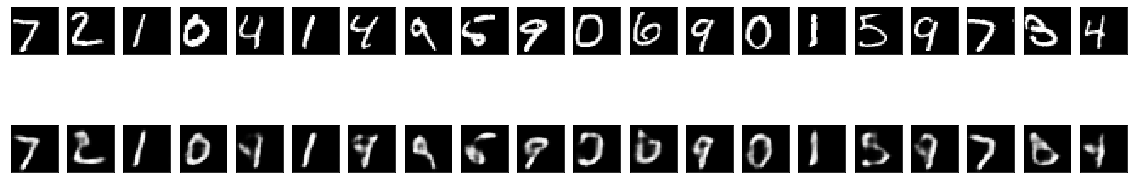

In [46]:
# test
n = 20
test = mnist_test_dcae[:n]
test = np.concatenate((test[:, :, 5:],test[:, :, :5]), axis=2)
decoded_img = dcae.predict(test)

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

位置情報って復元できるんだ？

In [15]:
mnist_label = (mnist_label_test[:80] @ np.arange(10)).astype(int)
model_vis.model_vis(encoder_mnist_dcae, mnist_test_dcae[:80], mnist_label, item_vis=model_vis.item_vis_for_mat, item_vis_label=[str(i) for i in range(28)], trans_data=model_vis.trans_data_mnist, output_path='./html/dcae_mat.html', output_title='dcae_mat')

In [16]:
mnist_label = (mnist_label_test[:80] @ np.arange(10)).astype(int)
model_vis.model_vis(encoder_mnist_dcae, mnist_test_dcae[:80], mnist_label, item_vis=model_vis.item_vis_for_img, trans_data=model_vis.trans_data_mnist, output_path='./html/dcae_img.html', output_title='dcae_img')

# iris, AE

In [17]:
# データセットの用意
from sklearn.datasets import load_iris
iris = load_iris()
iris_data = iris.data
iris_label = np.eye(3)[iris.target]
iris_label_name = iris.target_names[iris.target]

In [24]:
# model 作成
encoding_dim = 3
input_iris = Input(shape=(4,))
encoded_iris = Dense(encoding_dim, activation='relu')(input_iris)
decoded_iris = Dense(4, activation='sigmoid')(encoded_iris)

ae_iris = Model(input=input_iris, output=decoded_iris)
encoder_iris = Model(input_iris, encoded_iris)
tf.keras.backend.get_session().run(tf.global_variables_initializer())
ae_iris.compile(optimizer='adadelta', loss='binary_crossentropy')
ae_iris.summary()

/Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 16        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [25]:
# 訓練
ae_iris.fit(iris_data, iris_data,
                epochs=100,
                batch_size=256,
                shuffle=True)

Epoch 1/100
150/150 [==============================] - 1s 6ms/step - loss: -5.4356
Epoch 2/100
150/150 [==============================] - 0s 15us/step - loss: -5.4958
Epoch 3/100
150/150 [==============================] - 0s 18us/step - loss: -5.5568
Epoch 4/100
150/150 [==============================] - 0s 16us/step - loss: -5.6184
Epoch 5/100
150/150 [==============================] - 0s 16us/step - loss: -5.6804
Epoch 6/100
150/150 [==============================] - 0s 17us/step - loss: -5.7430
Epoch 7/100
150/150 [==============================] - 0s 19us/step - loss: -5.8063
Epoch 8/100
150/150 [==============================] - 0s 19us/step - loss: -5.8701
Epoch 9/100
150/150 [==============================] - 0s 16us/step - loss: -5.9346
Epoch 10/100
150/150 [==============================] - 0s 22us/step - loss: -5.9998
Epoch 11/100
150/150 [==============================] - 0s 17us/step - loss: -6.0656
Epoch 12/100
150/150 [==============================] - 0s 22us/step - loss

150/150 [==============================] - 0s 18us/step - loss: -21.1493
Epoch 98/100
150/150 [==============================] - 0s 17us/step - loss: -21.5244
Epoch 99/100
150/150 [==============================] - 0s 17us/step - loss: -21.9154
Epoch 100/100
150/150 [==============================] - 0s 17us/step - loss: -22.3178


In [26]:
encoder_iris.predict(iris.data)

array([[ 7.55257463e+00,  5.96641636e+00,  1.52081251e-04],
       [ 7.23911858e+00,  5.69830418e+00, -0.00000000e+00],
       [ 7.01989603e+00,  5.51983500e+00, -0.00000000e+00],
       [ 7.24498892e+00,  5.46857452e+00, -0.00000000e+00],
       [ 7.52462101e+00,  5.89154053e+00, -0.00000000e+00],
       [ 8.61775684e+00,  6.51624680e+00, -0.00000000e+00],
       [ 7.30896425e+00,  5.55093050e+00, -0.00000000e+00],
       [ 7.61435175e+00,  5.88643932e+00, -0.00000000e+00],
       [ 6.87859631e+00,  5.22247171e+00, -0.00000000e+00],
       [ 7.32231474e+00,  5.68358278e+00, -0.00000000e+00],
       [ 7.98371410e+00,  6.30430412e+00, -0.00000000e+00],
       [ 7.64817572e+00,  5.73158646e+00, -0.00000000e+00],
       [ 7.05745983e+00,  5.54617262e+00, -0.00000000e+00],
       [ 6.24378204e+00,  5.00110006e+00,  3.60585451e-02],
       [ 7.86312914e+00,  6.63602018e+00,  3.31504673e-01],
       [ 8.66932678e+00,  6.81871128e+00,  1.64351881e-01],
       [ 7.96449375e+00,  6.40138149e+00

In [27]:
model_vis.model_vis(encoder_iris, iris.data, iris_label_name, item_vis=model_vis.item_vis_for_mat, item_vis_label=iris.feature_names, output_path='./html/iris_mat.html', output_title='iris_mat')

[[1.         0.99999851 0.99999744 ... 0.98792976 0.98559403 0.98592365]
 [0.99999851 1.         0.99999982 ... 0.98819858 0.98588765 0.9862138 ]
 [0.99999744 0.99999982 1.         ... 0.98827803 0.98597443 0.98629975]
 ...
 [0.98792976 0.98819858 0.98827803 ... 0.99999994 0.99989605 0.99992239]
 [0.98559403 0.98588765 0.98597443 ... 0.99989605 1.         0.99999821]
 [0.98592365 0.9862138  0.98629975 ... 0.99992239 0.99999821 1.00000012]]


In [28]:
model_vis.model_vis(encoder_iris, iris.data, iris_label_name, item_vis=model_vis.item_vis_for_multidim, item_vis_label=iris.feature_names, output_path='./html/iris_muldim.html', output_title='iris_muldim')

# boston house price, AE


In [29]:
from sklearn.datasets import load_boston
boston = load_boston()
boston_data = boston.data
boston_label = boston.target
boston_label_thres = np.empty(boston_label.shape).astype('str')
boston_label_thres[boston_label>boston_label.mean()+5] = 'high'
boston_label_thres[(boston_label<=boston_label.mean()+5) * (boston_label>=boston_label.mean()-5)] = 'mid'
boston_label_thres[boston_label<boston_label.mean()-5] = 'low'
boston_label_thres

array(['mid', 'mid', 'high', 'high', 'high', 'high', 'mid', 'mid', 'low',
       'mid', 'low', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'low',
       'mid', 'mid', 'low', 'mid', 'low', 'low', 'low', 'low', 'low',
       'low', 'mid', 'mid', 'low', 'low', 'low', 'low', 'low', 'mid',
       'mid', 'mid', 'mid', 'high', 'high', 'mid', 'mid', 'mid', 'mid',
       'mid', 'mid', 'low', 'low', 'mid', 'mid', 'mid', 'mid', 'mid',
       'mid', 'high', 'mid', 'high', 'mid', 'mid', 'mid', 'low', 'mid',
       'mid', 'high', 'mid', 'mid', 'mid', 'low', 'mid', 'mid', 'mid',
       'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'high',
       'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'high',
       'mid', 'mid', 'mid', 'mid', 'mid', 'high', 'mid', 'high', 'high',
       'high', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid',
       'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'mid',
       'mid', 'mid', 'mid', 'mid', 'mid', 'mid', 'low', 'mid', 'mid',
     

In [30]:
# model 作成
encoding_dim = 4
input_boston = Input(shape=(13,))
encoded_boston = Dense(encoding_dim, activation='relu')(input_boston)
decoded_boston = Dense(13, activation='sigmoid')(encoded_boston)

ae_boston = Model(input=input_boston, output=decoded_boston)
encoder_boston = Model(input_boston, encoded_boston)
tf.keras.backend.get_session().run(tf.global_variables_initializer())
ae_boston.compile(optimizer='adadelta', loss='binary_crossentropy')
ae_boston.summary()

/Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 56        
_________________________________________________________________
dense_8 (Dense)              (None, 13)                65        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 訓練
ae_boston.fit(boston_data, boston_data,
                epochs=100,
                batch_size=256,
                shuffle=True)

Epoch 1/100
506/506 [==============================] - 1s 2ms/step - loss: -276.0594
Epoch 2/100
506/506 [==============================] - 0s 15us/step - loss: -297.5289
Epoch 3/100
506/506 [==============================] - 0s 16us/step - loss: -317.2444
Epoch 4/100
506/506 [==============================] - 0s 14us/step - loss: -334.0312
Epoch 5/100
506/506 [==============================] - 0s 17us/step - loss: -345.8709
Epoch 6/100
506/506 [==============================] - 0s 17us/step - loss: -351.7369
Epoch 7/100
506/506 [==============================] - 0s 16us/step - loss: -354.9136
Epoch 8/100
506/506 [==============================] - 0s 14us/step - loss: -357.6370
Epoch 9/100
506/506 [==============================] - 0s 16us/step - loss: -360.3257
Epoch 10/100
506/506 [==============================] - 0s 17us/step - loss: -363.4459
Epoch 11/100
506/506 [==============================] - 0s 15us/step - loss: -367.3568
Epoch 12/100
506/506 [==============================]

506/506 [==============================] - 0s 16us/step - loss: -1098.9932
Epoch 95/100
506/506 [==============================] - 0s 16us/step - loss: -1099.1715
Epoch 96/100
506/506 [==============================] - 0s 17us/step - loss: -1099.2404
Epoch 97/100
506/506 [==============================] - 0s 26us/step - loss: -1099.3398
Epoch 98/100
506/506 [==============================] - 0s 25us/step - loss: -1099.5484
Epoch 99/100
506/506 [==============================] - 0s 33us/step - loss: -1099.6692
Epoch 100/100
506/506 [==============================] - 0s 21us/step - loss: -1099.8293


In [32]:
model_vis.model_vis(encoder_boston, boston_data, boston_label_thres, item_vis=model_vis.item_vis_for_multidim, item_vis_label=boston.feature_names, output_path='./html/boston_muldim.html', output_title='boston_muldim')